# Convolutional Beta-Variational AutoEncoder

### This notebook contains a Tensorflow Keras-based Convolutional Variational Auto-Encoder (using mixture of sub-classing and functional api) trained on [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

In [89]:
try:
    %tensorflow_version 2.x
except:
    pass

import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np

In [90]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [91]:
# verify gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15775392549960662248
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6762114908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17056049657382175919
physical_device_desc: "device: 0, name: GeForce GTX 980M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [119]:
###### Constants ######
BATCH_SIZE=64
MAX_EPOCHS=5
PERCENT_VAL=0.2 # percentage of test data used for validation

# Autoencoder Parameters
LATENT_DIM = 10
INPUT_SHAPE = (28, 28, 1)
BETA = 10.0

# Save/Load Model Constants
SAVE_PATH = os.path.join('..', 'models', 'cvae')

LOADING_WEIGHTS = False
SAVING_WEIGHTS = False
TRAINING = True

In [120]:
###### Function Definitions ######
def normalize(images, labels):
    # Add channel
    images = tf.expand_dims(images, -1)
    images = tf.cast(images, tf.float32)
    images /= 255
    
    # Add channel
    labels = tf.expand_dims(labels, -1)
    labels = tf.cast(labels, tf.float32)
    labels /= 255
    
    return images, labels

def display_image(image):
    image = image if type(image) is np.ndarray else image.numpy()
    image = image.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def display_images(images, rows, cols, dpi=128, wspace=0, hspace=0, labels=None):
    fig = plt.figure(dpi=dpi)

    spec = gs.GridSpec(rows, cols)
    spec.update(wspace=wspace, hspace=hspace)

    i = 0
    for image in images:
        image = image if type(image) is np.ndarray else image.numpy()
        image = image.reshape(image.shape[:-1]) # remove channel
        ax = plt.subplot(spec[i])
        
        if labels:
            plt.title(labels[i])
            
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.show()
    
def split_data(data, percent):
    n = data.shape[0]
    indices = np.random.permutation(n)
    
    split = int(np.ceil(n * percent))
    return data[indices[split:]], data[indices[:split]]

def plot_history(history, metrics, figsize=(15,10)):
    plt.figure(figsize=figsize)

    for i, metrics in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        for metric in metrics:
            plt.plot(range(len(history.epoch)), history.history[metric], label=metric)
        plt.legend(loc='upper right')        

In [121]:
# 2nd elements are labels, which we don't need
(xtrain, xtrain_labels), (xtest, xtest_labels) = tf.keras.datasets.fashion_mnist.load_data()

xtest, xval = split_data(xtest, PERCENT_VAL)

n_training = xtrain.shape[0]
n_test = xtest.shape[0]
n_val = xval.shape[0]

In [122]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, xtrain)).map(normalize).cache().shuffle(n_training//10).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
val_ds = tf.data.Dataset.from_tensor_slices((xval, xval)).map(normalize).cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, xtest)).map(normalize).cache().batch(BATCH_SIZE)

## Visualizing a Few Exemplars from the **TEST** Data Set

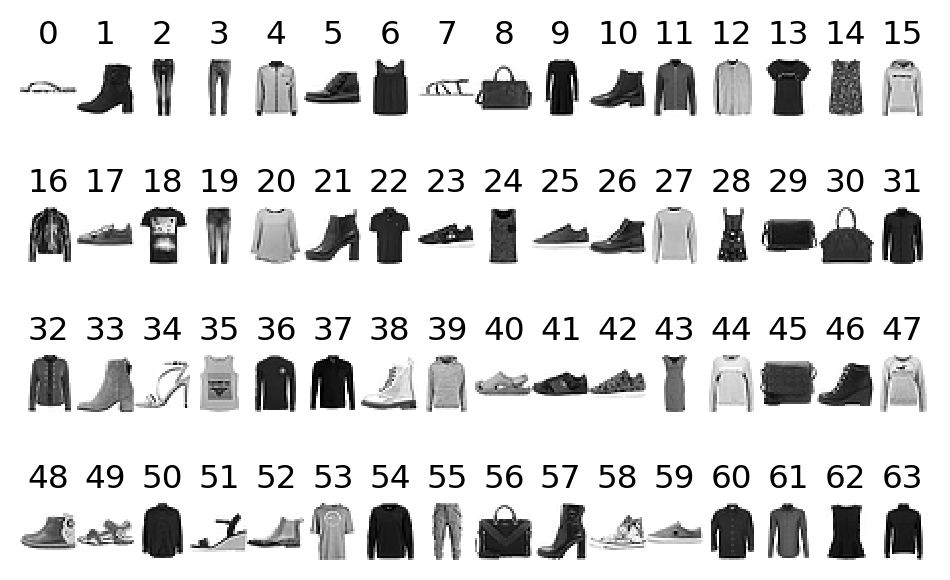

In [123]:
images, _ = next(iter(test_ds))
display_images(images, rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

# Defining the Keras Model (Using Sub-Classing)

In [131]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        # layers
        self.conv1 = tf.keras.layers.Conv2D(
          filters=16, 
          kernel_size=3, 
          strides=(1, 1), 
          padding='same', 
          activation='relu', 
          name='encoder/conv1')
        self.maxpool1 = tf.keras.layers.MaxPool2D(2)
        self.conv2 = tf.keras.layers.Conv2D(
          filters=32, 
          kernel_size=3, 
          strides=(1, 1), 
          padding='same', 
          activation='relu', 
          name='encoder/conv2')
        self.maxpool2 = tf.keras.layers.MaxPool2D(2)
        self.flatten = tf.keras.layers.Flatten(name='encoder/flatten')
        self.dense1 = tf.keras.layers.Dense(latent_dim, name='encoder/dense1', activation='relu')
        self.logvar = tf.keras.layers.Dense(latent_dim, name='encoder/logvar')
        
        # output distribution -- shape=(None, 2*latent_dim)
        self.mu = tf.keras.layers.Dense(latent_dim, name='encoder/mu')
        self.sigma = tf.keras.layers.Lambda(lambda t: tf.keras.backend.exp(.5*t), name='encoder/sigma')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.mu(x), self.logvar(x), self.sigma(self.logvar(x))


In [132]:
class Sampler(tf.keras.layers.Layer):
    def __init__(self):
        super(Sampler, self).__init__()
        
    def call(self, inputs):
        mu, sigma = inputs
        
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        
        # Gaussian noise
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return mu + sigma * epsilon

In [139]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(Decoder, self).__init__(*args, **kwargs)
        
        # layers
        self.dense1 = tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu, name='decoder/dense1')
        self.reshape1 = tf.keras.layers.Reshape(target_shape=(7, 7, 64), name='decoder/reshape1')
        self.trans_conv1 = tf.keras.layers.Conv2DTranspose(
          filters=32,
          kernel_size=3,
          strides=(1, 1),
          padding='same',
          activation='relu',
          name='decoder/deconv1')
        self.upsample1 = tf.keras.layers.UpSampling2D(2)
        self.trans_conv2 = tf.keras.layers.Conv2DTranspose(
          filters=16,
          kernel_size=3,
          strides=(1, 1),
          padding='same',
          activation='relu',
          name='decoder/deconv2')
        self.upsample2 = tf.keras.layers.UpSampling2D(2)

        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.reshape1(x)
        x = self.trans_conv1(x)
        x = self.upsample1(x)
        x = self.trans_conv2(x)
        x = self.upsample2(x)
        return x

# VAE Loss Function
<h2>
$
\begin{align}
\DeclareMathOperator{\ExpectedVal}{\mathbf{E}}
\DeclareMathOperator{\log}{\operatorname{log}}
\mathcal{L}(\theta, \phi; \mathbf{x}^{(i)}) = -D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z})) + \ExpectedVal_{q_\phi(\mathbf{z}\vert\mathbf{x^{(i)}})}\big[\log p_\theta(\mathbf{x}^{(i)}\vert \mathbf{z})\big],
\end{align}
$ 
<br><br>
where $D_{KL}$ is the KL-divergence.
<br><br><br><br>
If we assume that $p_\theta(\mathbf{z}) = \mathcal{N}(0, 1) \text{ and } q_\phi(\mathbf{z}\vert \mathbf{x}^{(i)})$ is Gaussian, then the KL-divergence can be integrated analytically and has the value
$    
\begin{align}
\DeclareMathOperator{\log}{\operatorname{log}}
D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z}) = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2),
\end{align}
$
<br>
where $J$ is the dimensionality of the latent vector $z$.
</h2>

In [140]:
encoder = Encoder(latent_dim=LATENT_DIM)
sampler = Sampler()
decoder = Decoder()

x = tf.keras.layers.Input(shape=INPUT_SHAPE)
mu, logvar, sigma = encoder(x)
z = sampler((mu, sigma))
x_recon = decoder(z) 

# Custom loss layer for reconstruction
class ReconstructionLoss(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super().__init__(**kwargs)

    def call(self, inputs):
        x = inputs[0]
        x_recon = inputs[1]
        
        recon_loss = tf.keras.backend.sum(tf.keras.backend.binary_crossentropy(x, x_recon), axis=(1,2))
        recon_loss = tf.keras.backend.mean(recon_loss)
        
        self.add_loss(recon_loss, inputs=inputs)
        
        return recon_loss

# Custom loss layer for kl-loss
class KLLoss(tf.keras.layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        self.is_placeholder = True
        super().__init__(**kwargs)
        
        self.beta = beta

    def call(self, inputs):
        mu = inputs[0]
        logvar = inputs[1]
        
        # KL Divergence for Gaussian Distributions (see Kingma and Welling, 2014, p.11)
        # --> Assumes that the prior p(Z) is normal and the posterior approximation q(z|x) is Gaussian
        kl_loss = -0.5 * self.beta * tf.keras.backend.sum(
            1.0 + logvar - tf.keras.backend.square(mu) - tf.keras.backend.exp(logvar), axis=-1)
        kl_loss = tf.keras.backend.mean(kl_loss)
        
        self.add_loss(kl_loss, inputs=inputs)
        
        return kl_loss

recon_loss = ReconstructionLoss(name='ReconLoss')([x, x_recon])
kl_loss = KLLoss(name='KL', beta=BETA)([mu, logvar])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = tf.keras.Model(inputs = x, outputs = [x_recon, recon_loss, kl_loss])
model.compile(optimizer=optimizer, loss=None)

## Visualize Reconstruction of Sampled Images *PRIOR TO TRAINING*.

### note: if not loading weights then this should look like random noise

In [141]:
# visualize generation before training
if TRAINING:
    images, _ = next(iter(test_ds))

    xs, _, _ = model(images)  # reconstructed images

    display_images(images=xs, rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

ValueError: cannot reshape array of size 12544 into shape (28,28)

<Figure size 1176x784 with 0 Axes>

## Train The Model and Display Metrics For Model Performance on **Training** and **Validation** Data Sets

Train for 938.0 steps, validate for 32.0 steps
Epoch 1/5
938/938 [==============================] - 11s 11ms/step - loss: 393.3741 - val_loss: 386.9712
Epoch 2/5
938/938 [==============================] - 9s 10ms/step - loss: 385.5053 - val_loss: 386.5225
Epoch 3/5
938/938 [==============================] - 9s 10ms/step - loss: 385.0745 - val_loss: 386.1617
Epoch 4/5
938/938 [==============================] - 9s 10ms/step - loss: 384.9248 - val_loss: 385.8671
Epoch 5/5
938/938 [==============================] - 9s 10ms/step - loss: 384.8155 - val_loss: 385.5802


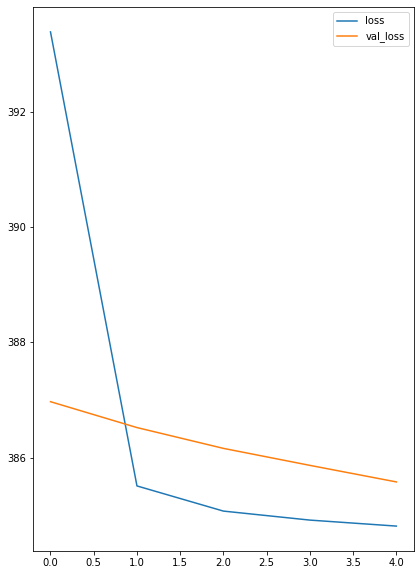

In [136]:
tf.autograph.set_verbosity(10)
if TRAINING:
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(train_ds, 
                        callbacks=[early_stop_callback],
                        epochs=MAX_EPOCHS, 
                        steps_per_epoch=np.ceil(n_training/BATCH_SIZE), 
                        validation_data=val_ds, 
                        validation_steps=np.ceil(n_val/BATCH_SIZE))
    
    plot_history(history, metrics=[('loss', 'val_loss')])

## Visualize Reconstruction of Sampled Images *AFTER TRAINING*.

### note: these are images from the **TEST** data set: the auto-encoder was NOT trained on these!

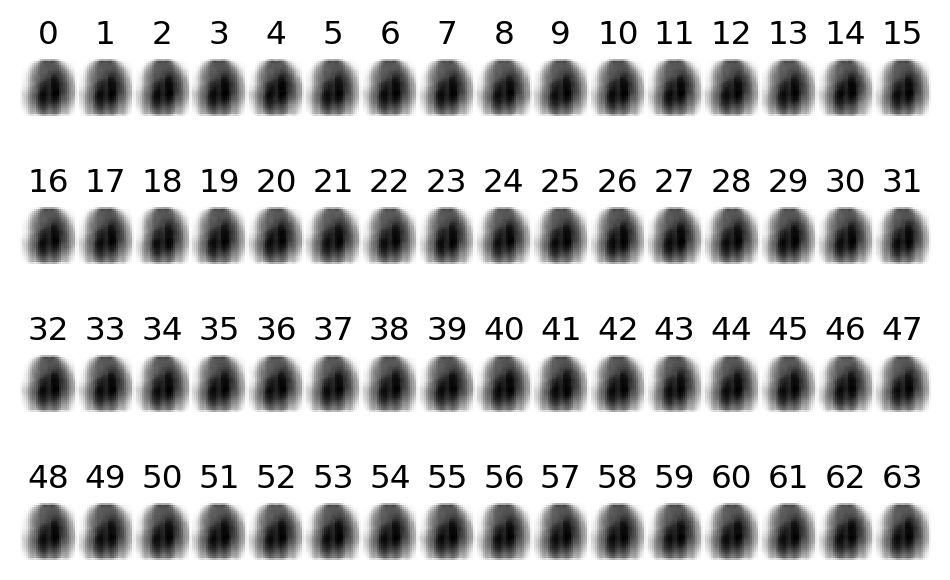

In [115]:
# visualize generation after training
images, _ = next(iter(test_ds))

xs, _, _ = model(images) # latent vectors

display_images(xs, rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

<hr>
<h1> Several Experiments on Learned Latent Vectors </h1>
<h2> (that is, reduced representation produced by the encoder) </h2>
<h3>I will be using the <i>cosine similarity (ala scipy)</i> to compare the latent vectors.</h3>
<h2>
$
\begin{align}
\text{cosine similarity} \equiv 1 - \frac{\vec{u} \cdot \vec{v}}{\| u \| \| v \|}
\end{align}
$
</h2>

<h3>note: the range of this distance metric is from $0$ (identical) to $2$ (most dissimilar).</h3>


In [38]:
import scipy.spatial.distance

## Illustration of Cosine Similarity Distance Metric 

In [39]:
# Examples for cosine similarity distance metric

# identical vectors
u = np.random.rand(100)
v = u

scipy.spatial.distance.cosine(u, v)

0.0

In [40]:
# orthogonal vectors
u = np.random.rand(100)
v = np.random.rand(100)

# apply Gram-Schmidt to make v orthogonal to u
v -= v.dot(u) * u / np.linalg.norm(u)**2

scipy.spatial.distance.cosine(u, v)

1.0

In [41]:
# opposite vectors
u = np.random.rand(100)
v = -u

scipy.spatial.distance.cosine(u, v)

2.0

## Examining a Sample of Latent Vectors

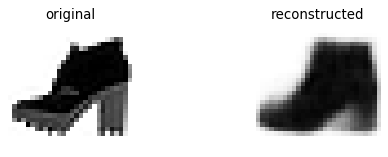

In [42]:
images, _ = next(iter(test_ds))

mu, _, sigma = encoder(images)
zs = sampler((mu, sigma))
xs = decoder(zs)

# change query_idx to test similarities between various types of objects
query_idx = 36
display_images([images[query_idx], xs[query_idx]], rows=1, cols=2, dpi=80, wspace=1, labels=['original', 'reconstructed'])

In [88]:
mu[:,0]

<tf.Tensor: id=120419, shape=(64,), dtype=float32, numpy=
array([-0.08367407,  1.2687687 ,  1.1084064 , -3.1294155 , -0.09940445,
       -1.5948963 ,  1.0016868 , -0.04211104, -1.2155203 ,  2.807972  ,
        1.0266242 ,  0.380247  , -1.5424914 , -0.97749484, -0.8931656 ,
        0.66048276,  0.8528938 , -0.65944606,  0.7414726 , -0.15044248,
        0.16306508,  0.7522048 ,  0.0516901 , -0.02566421, -0.0382508 ,
        0.6018766 , -0.3925842 ,  0.4785781 ,  0.41995907, -1.3018314 ,
        0.17167914,  0.28466046,  0.35580432,  0.45192313, -3.0180244 ,
        1.4733762 , -2.0258627 ,  2.7439494 ,  1.4829546 ,  2.0182562 ,
       -1.1224413 , -0.6791798 , -0.84297013,  1.783007  ,  0.5858363 ,
        0.7095214 , -1.1576705 ,  0.9297575 ,  0.08922553, -1.345221  ,
        0.5436542 , -0.45293215,  0.5729419 ,  0.32394075, -0.63507366,
        0.22628915, -1.0147523 , -0.06424034, -1.1951122 ,  0.6335801 ,
       -0.52744085,  0.8154243 , -2.0520687 ,  1.1063024 ], dtype=float32)>

In [51]:
sampling_dists = mu #np.concatenate((mu, sigma), axis=-1)
dists = []
for i, other in enumerate(mu):
    dists.append([i, scipy.spatial.distance.cosine(mu[query_idx], other)])

dists = np.array(sorted(dists, key=lambda t: t[1]))

In [52]:
def format_scores(dists, indices=None, decimals=2):
    if indices is None:
        return list(map(str, np.round(dists[:,1], decimals=2)))        
    else:
        return list(map(str, np.round(dists[np.isin(dists[:,0], indices)][:,1], decimals=2)))

## Most Similar Exemplar (based on cosine similarity)

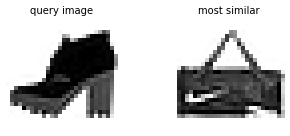

In [53]:
idx_best_match = int(dists[1,0])

display_images([images[query_idx], images[idx_best_match]], rows=1, cols=2, dpi=60, wspace=0.5, labels=['query image', 'most similar'])

## Least Similar Exemplar (based on cosine similarity)

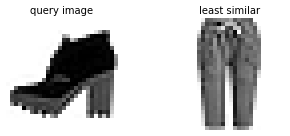

In [54]:
idx_worst_match = int(dists[-1,0])

display_images([images[query_idx], images[idx_worst_match]], rows=1, cols=2, dpi=60, wspace=0.5, labels=['query image', 'least similar'])

## All Examples _Below_ Given Cosine Similarity Threshold

### note: plots show image and cosine similarity value

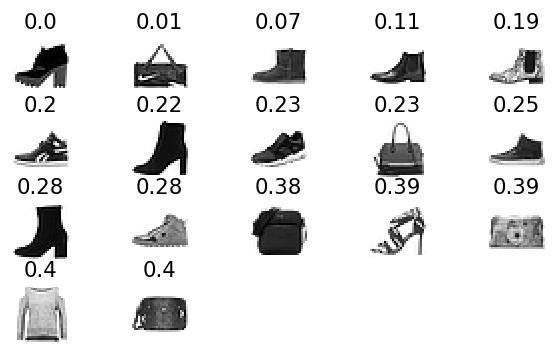

In [55]:
sim_thresh = 0.4

# indicies (of latent vectors) having cosine similarities below given threshold
indices = dists[:,0][dists[:,1] < sim_thresh].astype(int)

# cosine similaritity values (lower is closer match to query image)
scores = format_scores(dists, indices, decimals=2)

display_images(images.numpy()[indices], rows=5, cols=5, labels=scores, hspace=0.5)

## All Examples _Above_ Given Threshold Given Cosine Similarity Threshold

### note: plots show image and cosine similarity value

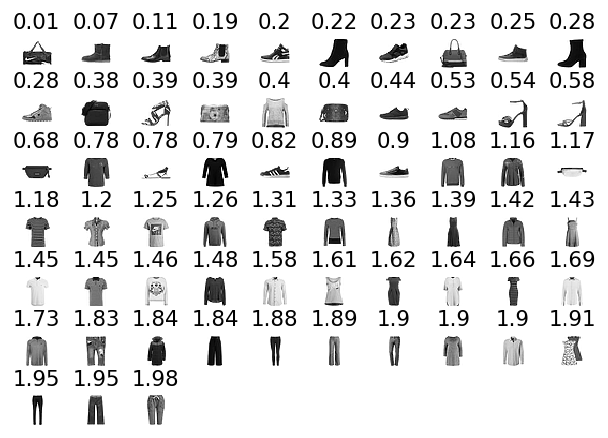

In [50]:
sim_thresh = 0

# indicies (of latent vectors) having cosine similarities below given threshold
indices = dists[:,0][dists[:,1] > sim_thresh].astype(int)

# cosine similaritity values (lower is closer match to query image)
scores = format_scores(dists, indices, decimals=2)

display_images(images.numpy()[indices], rows=7, cols=10, labels=scores, hspace=1)

In [32]:
if SAVING_WEIGHTS:
    try:
        model.save_weights(SAVE_PATH, save_format='tf')
    except Exception as e:
        print(e)